In [67]:
import torch
import numpy as np

import gymnasium as gym
import speederbikes_sim
from ppo.PPOAgent import PPOAgent as Agent
from ppo.PPOTrainer import PPOTrainer as Trainer

import seaborn as sns
import matplotlib.pyplot as plt

Training with a script

In [2]:
# ...

Training with interactive code:

In [3]:
# setup all components
sim_speedup = 8
env = gym.make('speederbikes/SpeederBikes-v0', render_mode="human", observation_mode="flatten",
                lvl_n_lanes=3, lvl_speed= 200 * sim_speedup, lvl_road_width= 350, 
                agt_speed= 200 * sim_speedup 
               )

obs, info = env.reset()
env.metadata["render_fps"] = 60 * sim_speedup

In [4]:
agent = Agent(env, hidden_sizes=[64, 64], pi_lr=0.0003, v_lr=0.001, activation=torch.nn.Tanh)

In [13]:
steps_per_epoch = 2000
max_traj_len = 1000
validation_steps = 1000

trainer = Trainer(agent, 
                  epochs=200,
                  steps_per_epoch=steps_per_epoch,
                  max_traj_len=max_traj_len,
                  pi_train_max_iters=80,
                  v_train_iters=80,
                  target_kl=0.01,

                  validation_interval=20,
                  validation_steps=validation_steps,
                  goal_reward=validation_steps*1,
                  seed=4,
                  log_dir="./logs",
                  storage_dir="./trained_models/"
)

In [22]:
# trainer.start()

Linear(in_features=20, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=3, bias=True)


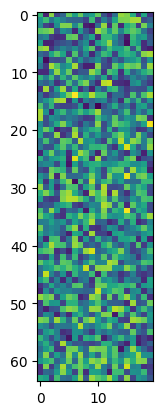

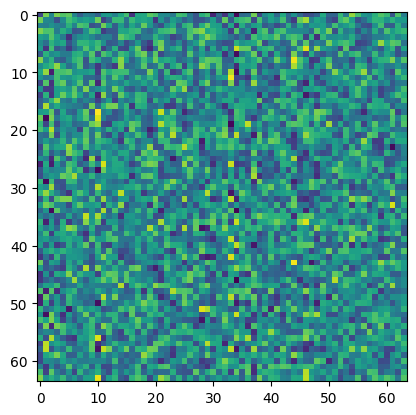

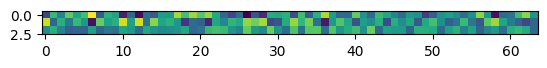

In [76]:
weights = []
for m in agent.pi.modules():
    if isinstance(m, torch.nn.Linear):
        print(m)
        weights.append(m.weight.data)

for w in weights:
    plt.imshow(w)
    plt.show()

---

Other tests and learnings

In [14]:
s = slice(3, 20)
l = [1, 2, 3, 4, 5, 6, 7] * 8
l[s]

[4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6]

In [2]:
# locals()

In [11]:
import torch
from torch import nn
from torch.distributions.categorical import Categorical

In [70]:
a = Categorical(torch.tensor([0.4, 0.6]))
b = Categorical(logits=torch.tensor([0.4, 0.6]))
print(a.probs)
print(b.probs)

tensor([0.4000, 0.6000])
tensor([0.4502, 0.5498])


In [71]:
b.log_prob(torch.tensor(0))
a.entropy()

tensor(-0.7981)

In [51]:
import numpy as np
import scipy

In [123]:
rews = np.array([1, 0, 1, 1, 1], dtype=np.float32)
vals = np.array([2, 2, 3, 4, 1], dtype=np.float32)

gamma = 0.99
lam = 0.95

q_1_step_estimates = rews[:-1] + gamma * vals[1:]
adv_1_step_estimates = q_1_step_estimates - vals[:-1]
adv_1_step_estimates_inverted = adv_1_step_estimates[::-1]
print(adv_1_step_estimates)

[ 0.98  0.97  1.96 -2.01]


In [122]:
fac = float(- gamma * lam)

a = scipy.signal.lfilter(
    [1],
    [1, fac],
    adv_1_step_estimates[::-1],
    axis=0
)#[::-1]

print(a[::-1])

[ 1.95384467  1.03545417  0.06959505 -2.00999999]


In [130]:
def weighted_adv_avg(advantages, discount):
    advs = advantages[::-1] # invert order
    res = [0]
    for i in range(len(advantages)):
        r = advs[i] + discount * res[-1]
        res.append(r)
    return np.array(res[1:])[::-1]

weighted_adv_avg(adv_1_step_estimates, gamma*lam)

array([ 1.95384467,  1.03545417,  0.06959505, -2.00999999])

In [131]:
def weighted_adv_avg2(advantages, discount):
    res = []
    for i in range(len(advantages)):
        r = 0
        j = i
        while j < len(advantages):
            r += discount**(j-i) * advantages[j]
            j += 1 
        res.append(r)
    return np.array(res)

weighted_adv_avg2(adv_1_step_estimates, gamma*lam)

array([ 1.95384467,  1.03545417,  0.06959505, -2.00999999])

In [121]:
a = 1 * adv_1_step_estimates_inverted[0]
b = 1 * adv_1_step_estimates_inverted[1] - fac * a
c = 1 * adv_1_step_estimates_inverted[2] - fac * b
d = 1 * adv_1_step_estimates_inverted[3] - fac * c
print((a, b, c, d))

(-2.009999990463257, 0.06959504711627962, 1.0354541704230904, 1.9538446663564029)


In [108]:
adv_1_step_estimates[0] + fac *  adv_1_step_estimates[1] + fac * adv_1_step_estimates[2] + fac * adv_1_step_estimates[3]

0.8399999618530274